## Johnson-lindenstrauss lemma in arbitrary dimension

Johnson-lindenstrauss lemma 를 임의의 차원에서 만족하는 백터쌍의 각도 분포를 구합니다.

In [10]:
import torch
from torchtyping import TensorType
import einops

In [11]:
DIMENSIONS = 100
VECTOR_COUNT = 1000

vector_set: TensorType['VECTOR_COUNT', 'DIMENSIONS'] = \
    (torch.rand((VECTOR_COUNT, DIMENSIONS)) * 2 - 1).requires_grad_(True)

In [12]:
import torch.nn.functional as F

def calculate_loss(vector_set: TensorType["VECTOR_COUNT", "DIMENSIONS"]) -> TensorType[1]:
    dot_product = torch.matmul(
        vector_set, 
        vector_set.transpose(-2,-1)
    )
    target_matrix = torch.eye(VECTOR_COUNT)
    orthogonality_loss = F.mse_loss(dot_product, target_matrix)
    size_loss = F.mse_loss(torch.diag(dot_product), torch.ones(VECTOR_COUNT))
    return orthogonality_loss + size_loss

In [13]:
print(calculate_loss(vector_set).item())

1057.9891357421875


In [14]:
"""
내적의 결과를 분포로 나타낸다.
내적의 결과가 최대인 경우와 최소인 경우 사이를 고려한다.
"""
dot_product = torch.matmul(
    vector_set,
    vector_set.transpose(-2, -1)
)
diagonal_comp = torch.diag_embed(dot_product.diagonal())

MAX_CO_SIMILARITY = round(torch.max(dot_product - diagonal_comp).item())
MIN_CO_SIMILARITY = round(torch.min(dot_product - diagonal_comp).item())

In [15]:
print("MAX: ", MAX_CO_SIMILARITY)
print("MIN: ", MIN_CO_SIMILARITY)

MAX:  15
MIN:  -15


In [16]:
rounded_similarity = torch.round(dot_product - diagonal_comp).long()
distribution = {sim: 0 for sim in range(MIN_CO_SIMILARITY, MAX_CO_SIMILARITY + 1)}

for i in range(VECTOR_COUNT):
    for j in range(VECTOR_COUNT):
        sim = rounded_similarity[i][j].item()
        distribution[sim] += 1

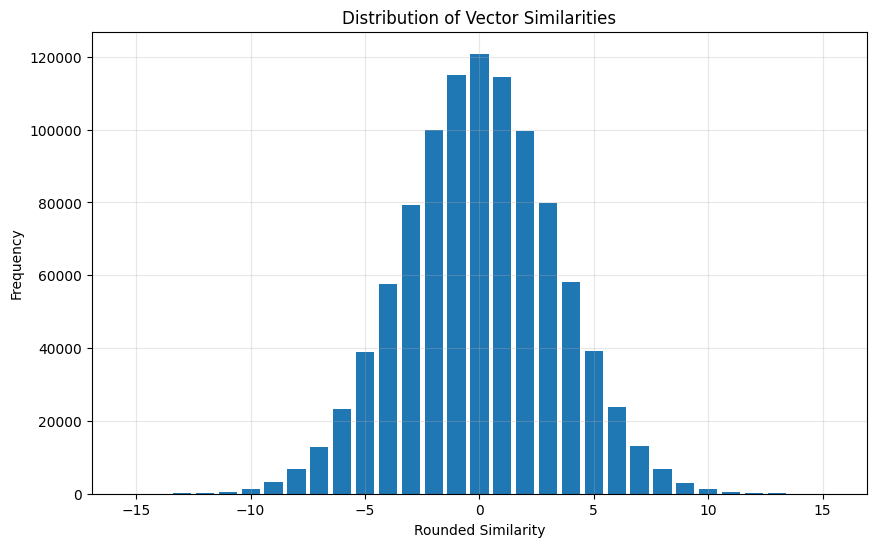

In [17]:
import matplotlib.pyplot as plt

# Create lists for x and y values
x_values = list(distribution.keys())
y_values = list(distribution.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values)
plt.xlabel('Rounded Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Vector Similarities')
plt.grid(True, alpha=0.3)
plt.show()


In [18]:
LR_INIT = 2e-4
ITERATIONS = 10000

optim = torch.optim.AdamW([vector_set], lr=LR_INIT)

for i in range(ITERATIONS):
    optim.zero_grad()
    loss = calculate_loss(vector_set)
    loss.backward()
    optim.step()
    if i % 1000 == 0:
        print(f'Iteration {i:6d}, Loss: {loss.item():.6f}')

Iteration      0, Loss: 1057.989136
Iteration   1000, Loss: 343.983978
Iteration   2000, Loss: 129.241547
Iteration   3000, Loss: 51.209789
Iteration   4000, Loss: 20.334099
Iteration   5000, Loss: 7.790434
Iteration   6000, Loss: 2.773745
Iteration   7000, Loss: 0.875046
Iteration   8000, Loss: 0.229297
Iteration   9000, Loss: 0.048577


In [27]:
"""
내적의 결과를 분포로 나타낸다.
내적의 결과가 최대인 경우와 최소인 경우 사이를 고려한다.
"""
dot_product = torch.matmul(
    vector_set,
    vector_set.transpose(-2, -1)
)
diagonal_comp = torch.diag_embed(dot_product.diagonal())

MAX_CO_SIMILARITY = round(torch.max(dot_product - diagonal_comp).item(), 2)
MIN_CO_SIMILARITY = round(torch.min(dot_product - diagonal_comp).item(), 2)

In [28]:
print("MAX: ", MAX_CO_SIMILARITY)
print("MIN: ", MIN_CO_SIMILARITY)

MAX:  0.46
MIN:  -0.48


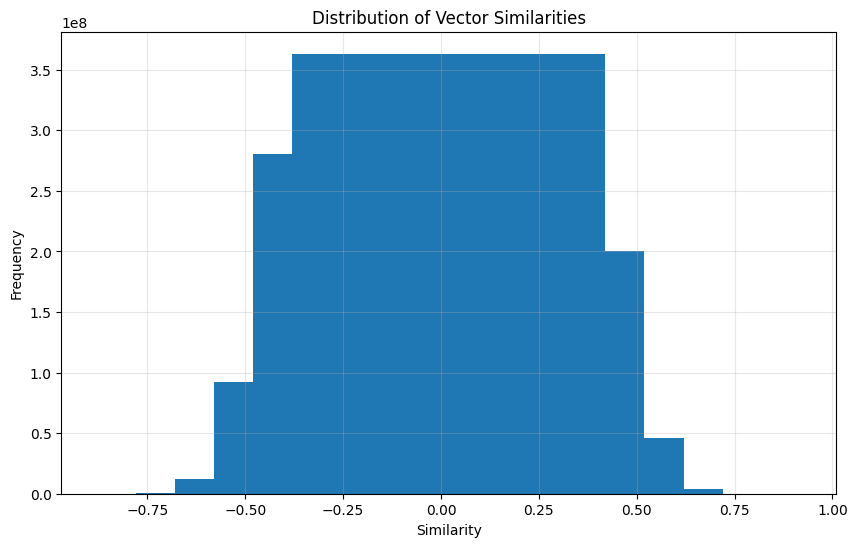

In [29]:
# Create histogram of similarities
similarities = dot_product - diagonal_comp
similarities = similarities[torch.triu_indices(similarities.size(0), similarities.size(1), offset=1)]

x_values = torch.arange(MIN_CO_SIMILARITY, MAX_CO_SIMILARITY + 0.1, 0.1)
y_values = torch.zeros_like(x_values)

for i, x in enumerate(x_values):
    y_values[i] = torch.sum((similarities >= x - 0.05) & (similarities < x + 0.05))

plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Vector Similarities')
plt.grid(True, alpha=0.3)
plt.show()
